In [4]:
# %pip install torch torchvision matplotlib
# CHECK CLASS NAMES BEFORE RUNNING NEW MODELS

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from IPython.display import Image as Ipimage, display
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_classes = 8  # DANGER
model = models.resnet50()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(model.fc.in_features, num_classes)
) 
model.load_state_dict(torch.load("resnet50_model5.pth", map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode
class_names = ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']

model_dense = models.densenet121()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model_dense.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),  # Apply dropout for regularization
    torch.nn.Linear(model_dense.classifier.in_features, num_classes)
)
model_dense.load_state_dict(torch.load("densenet121_model1.pth", map_location=device))
model_dense.to(device)
model_dense.eval()  # Set model to evaluation mode
class_names = ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']

num_classes_old = 6  # DANGER
model_old = models.resnet50()
model_old.fc = torch.nn.Linear(model_old.fc.in_features, num_classes_old)
model_old.load_state_dict(torch.load("resnet50_model_old.pth", map_location=device))
model_old.to(device)
model_old.eval()  # Set model to evaluation mode
class_names_old = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

num_classes_battery_soda = 2  # DANGER
model_battery_soda = models.resnet50()
model_battery_soda.fc = torch.nn.Linear(model_battery_soda.fc.in_features, num_classes_battery_soda)
model_battery_soda.load_state_dict(torch.load("resnet50_battery_soda.pth", map_location=device))
model_battery_soda.to(device)
model_battery_soda.eval()  # Set model to evaluation mode
class_names_battery_soda = ['battery', 'soda']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



num_classes_vit = 9  # DANGER
model_vit = models.vit_b_16()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model_vit.heads.head = torch.nn.Linear(model_vit.heads.head.in_features, num_classes_vit)

model_vit.load_state_dict(torch.load("./server/vit_model.pth", map_location=device))
model_vit.to(device)
model_vit.eval()  # Set model to evaluation mode
class_names_vit = ['battery', 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'syringe', 'trash']




In [ ]:
def classify_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names[class_idx]

    print(f"Resnet Predicted Class: {class_name}", end=' | ')

def classify_image_old(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_old(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_old[class_idx]

    print(f"Old Predicted Class: {class_name}", end=' | ')

def classify_dense(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_old(image)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_old[class_idx]

    print(f"Dense Predicted Class: {class_name}", end=' | ')

def classify_battery_soda(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    with torch.no_grad():
        outputs = model_battery_soda(image)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_battery_soda[class_idx]

    # print(f"probabilities: {probabilities}")
    # print(f"Dense Predicted Class: {class_name}", end=' | ')
    return probabilities, class_name

def classify_image_vit(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    model_vit.to(device)
    model_vit.eval()

    # Predict
    with torch.no_grad():
        outputs = model_vit(image)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        class_idx = predicted.item()
        class_name = class_names_vit[class_idx]

    probs = probs.squeeze(0)
    scores = {}
    for i in range(len(class_names_vit)):
        scores[class_names_vit[i]] = round(probs[i].item(), 4)
    return scores, class_name

def display_image(image_path):
    img = Image.open(image_path)
    max_width = 300
    max_height = 200
    img.thumbnail((max_width, max_height))
    display(img)

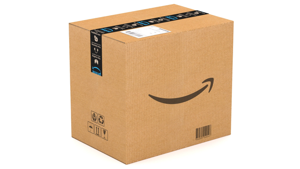

tensor([6.5148e-05, 9.9578e-01, 1.5674e-04, 2.3042e-05, 2.3410e-05, 3.9327e-03,
        6.5649e-06, 7.0665e-06, 3.1338e-06])
cardboard

-----------------------------------------------------------




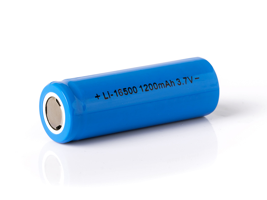

tensor([9.9885e-01, 6.2410e-05, 1.2995e-05, 5.9659e-05, 7.5753e-04, 7.6540e-06,
        1.9206e-04, 2.6146e-06, 5.1251e-05])
battery

-----------------------------------------------------------




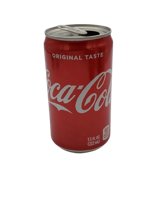

tensor([2.1422e-03, 9.9006e-04, 2.7291e-05, 2.1909e-04, 9.9561e-01, 7.3706e-04,
        2.6491e-04, 4.5603e-07, 4.1306e-06])
metal

-----------------------------------------------------------




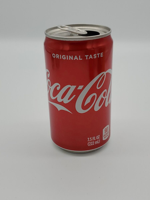

tensor([3.3968e-03, 3.7874e-04, 2.9685e-05, 3.3942e-04, 9.9398e-01, 1.0603e-03,
        8.0986e-04, 1.0843e-06, 5.7565e-06])
metal

-----------------------------------------------------------




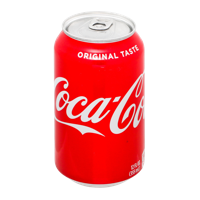

tensor([1.0020e-03, 1.3058e-04, 1.4917e-05, 2.4981e-04, 9.9822e-01, 2.3789e-04,
        1.3088e-04, 2.3061e-06, 1.0194e-05])
metal

-----------------------------------------------------------




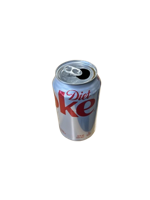

tensor([4.6357e-03, 2.6816e-04, 2.7850e-05, 8.2802e-05, 9.9139e-01, 3.0362e-03,
        2.7766e-04, 5.1856e-06, 2.7404e-04])
metal

-----------------------------------------------------------




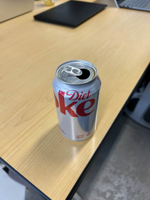

tensor([2.4685e-02, 8.8945e-04, 3.4209e-05, 1.9659e-04, 9.4581e-01, 2.1540e-02,
        3.2715e-03, 4.0509e-05, 3.5363e-03])
metal

-----------------------------------------------------------




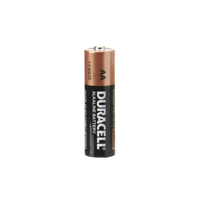

tensor([9.9995e-01, 9.0890e-06, 5.6381e-07, 1.4623e-07, 1.7510e-05, 1.6235e-05,
        1.1409e-06, 1.5564e-06, 2.9536e-06])
battery

-----------------------------------------------------------




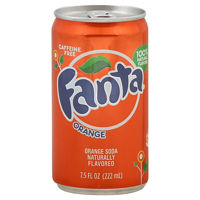

tensor([7.6378e-03, 7.1580e-03, 1.1912e-02, 2.2787e-03, 9.6601e-01, 1.9048e-03,
        2.7815e-03, 3.7536e-05, 2.8282e-04])
metal

-----------------------------------------------------------




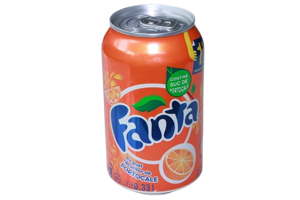

tensor([3.3564e-04, 1.7226e-04, 1.9557e-03, 4.0155e-03, 9.9216e-01, 1.5206e-04,
        1.1657e-03, 1.6441e-05, 2.4923e-05])
metal

-----------------------------------------------------------




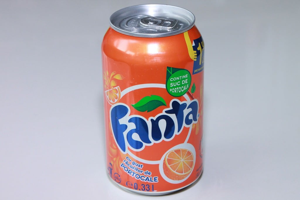

tensor([2.7127e-03, 3.4460e-04, 9.2618e-03, 1.0690e-02, 9.7356e-01, 3.4791e-04,
        3.0003e-03, 2.2632e-05, 6.1037e-05])
metal

-----------------------------------------------------------




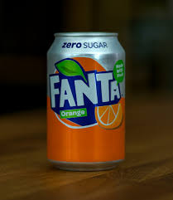

tensor([9.4614e-04, 7.2215e-03, 1.1702e-01, 9.9418e-02, 7.5477e-01, 2.3323e-03,
        1.5015e-02, 5.3835e-05, 3.2250e-03])
metal

-----------------------------------------------------------




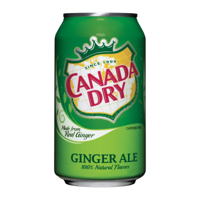

tensor([3.7069e-03, 3.7702e-04, 1.8352e-03, 5.2469e-03, 9.8283e-01, 9.6462e-05,
        5.1900e-03, 3.2371e-05, 6.8840e-04])
metal

-----------------------------------------------------------




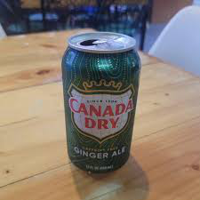

tensor([2.0882e-03, 7.4491e-05, 9.7825e-05, 3.7125e-03, 9.8958e-01, 3.3356e-03,
        9.7608e-04, 2.9146e-05, 1.0484e-04])
metal

-----------------------------------------------------------




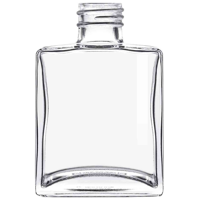

tensor([1.5721e-04, 1.6537e-04, 4.1712e-04, 9.0305e-01, 2.7438e-02, 4.5300e-03,
        6.3620e-02, 1.7763e-04, 4.4765e-04])
glass

-----------------------------------------------------------




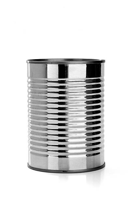

tensor([7.2067e-03, 5.4653e-05, 1.0113e-06, 2.9062e-04, 9.8791e-01, 2.7981e-03,
        1.5144e-03, 4.7904e-05, 1.8099e-04])
metal

-----------------------------------------------------------




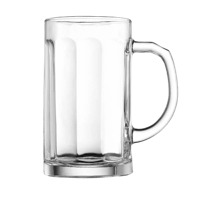

tensor([0.0090, 0.0031, 0.0051, 0.5331, 0.2576, 0.1651, 0.0038, 0.0225, 0.0006])
glass

-----------------------------------------------------------




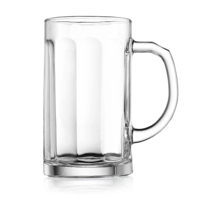

tensor([6.2076e-03, 7.4183e-04, 5.6509e-03, 2.8163e-01, 6.2821e-01, 5.4874e-02,
        1.5144e-03, 2.0692e-02, 4.7890e-04])
metal

-----------------------------------------------------------




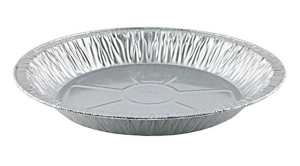

tensor([0.0035, 0.0017, 0.0970, 0.0680, 0.5238, 0.0012, 0.1408, 0.0020, 0.1621])
metal

-----------------------------------------------------------




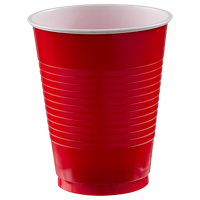

tensor([2.9231e-04, 1.0816e-04, 4.8385e-05, 3.7996e-03, 4.9543e-02, 8.4663e-01,
        9.7950e-02, 1.1307e-03, 4.9691e-04])
paper

-----------------------------------------------------------




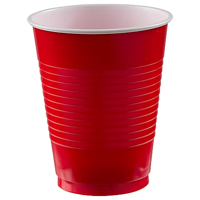

tensor([1.7629e-04, 6.5260e-05, 3.6283e-05, 5.2726e-04, 1.1528e-02, 9.5345e-01,
        3.3604e-02, 3.8210e-04, 2.3399e-04])
paper

-----------------------------------------------------------




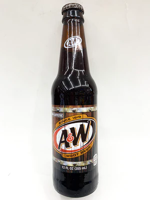

tensor([1.0739e-02, 1.0083e-02, 6.8722e-03, 9.1701e-01, 8.7066e-03, 3.0648e-03,
        2.2700e-02, 3.6319e-04, 2.0462e-02])
glass

-----------------------------------------------------------




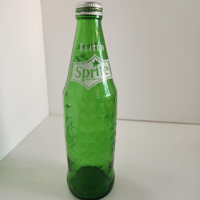

tensor([1.6939e-04, 1.1261e-04, 2.1538e-03, 9.8700e-01, 2.1384e-03, 1.7507e-03,
        6.3552e-03, 1.0586e-04, 2.1459e-04])
glass

-----------------------------------------------------------




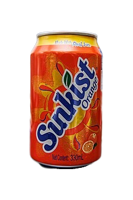

tensor([7.7309e-05, 3.4992e-05, 6.8672e-05, 3.7652e-03, 9.9389e-01, 6.3106e-05,
        2.0198e-03, 1.2725e-06, 7.8422e-05])
metal

-----------------------------------------------------------




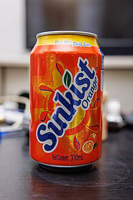

tensor([1.2488e-04, 5.6879e-03, 3.0913e-02, 5.9893e-02, 8.9533e-01, 7.9606e-04,
        6.9268e-03, 8.8741e-05, 2.4190e-04])
metal

-----------------------------------------------------------




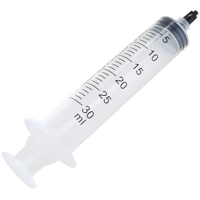

tensor([4.3914e-05, 1.2053e-05, 2.5046e-05, 1.3618e-05, 1.4774e-05, 4.0224e-05,
        3.6390e-05, 9.9981e-01, 5.6142e-06])
syringe

-----------------------------------------------------------




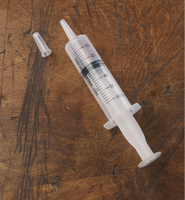

tensor([1.5037e-03, 1.9915e-03, 1.3045e-03, 2.2363e-04, 6.1781e-04, 4.3322e-03,
        3.5255e-03, 9.8603e-01, 4.7603e-04])
syringe

-----------------------------------------------------------




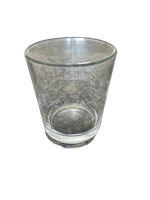

tensor([0.0160, 0.0029, 0.0306, 0.2359, 0.0462, 0.3204, 0.3326, 0.0087, 0.0066])
plastic

-----------------------------------------------------------




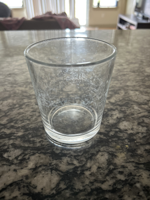

tensor([0.0032, 0.0105, 0.2230, 0.1383, 0.0097, 0.5010, 0.0869, 0.0210, 0.0064])
paper

-----------------------------------------------------------




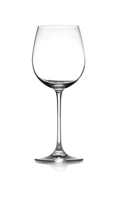

tensor([0.0118, 0.0314, 0.0162, 0.6021, 0.0674, 0.0448, 0.0046, 0.0033, 0.2185])
glass

-----------------------------------------------------------




In [ ]:
for test_image_path in os.listdir('custom-test-images'):
    image_path = f"./custom-test-images/{test_image_path}"
    display_image(image_path)
    scores, class_name = classify_image_vit(image_path)
    print(scores)
    print(class_name)
    # print('expected: cardboard\n')
    
    # classify_image(image_path)
    # classify_image_old(image_path)
    # classify_dense(image_path)
    print('\n-----------------------------------------------------------\n\n')


In [5]:
image_path = "./custom-test-images/amazon-cardboard-box-03.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: cardboard')


Predicted Class: cardboard | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: cardboard


In [43]:
image_path = "./custom-test-images/coke-real.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [7]:
image_path = "./custom-test-images/dietcoke.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: metal | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: metal


In [8]:
image_path = "./custom-test-images/dietcoke-removebg-preview.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')


Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [9]:
image_path = "./custom-test-images/mugs.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')


Predicted Class: battery | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [10]:
image_path = "./custom-test-images/Duracell_AA__49529.jpg"
classify_image(image_path)
classify_dense(image_path)
print('expected: battery')

Predicted Class: battery | Dense Predicted Class: metal | expected: battery


In [11]:
image_path = "./custom-test-images/wine-glass.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [12]:
image_path = "./custom-test-images/glass-container.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: metal | Old Predicted Class: metal | Dense Predicted Class: metal | expected: glass


In [13]:
image_path = "./custom-test-images/sprite.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [14]:
image_path = "./custom-test-images/fanta.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')

Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [15]:
image_path = "./custom-test-images/pie.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: metal')

Predicted Class: metal | Old Predicted Class: metal | Dense Predicted Class: metal | expected: metal


In [16]:
image_path = "./custom-test-images/root-beer.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: glass | Old Predicted Class: glass | Dense Predicted Class: glass | expected: glass


In [17]:
image_path = "./custom-test-images/syringe.webp"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: syringe')

Predicted Class: syringe | Old Predicted Class: glass | Dense Predicted Class: glass | expected: syringe


In [18]:
image_path = "./custom-test-images/syringe_with_bg.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: syringe')

Predicted Class: syringe | Old Predicted Class: cardboard | Dense Predicted Class: cardboard | expected: syringe


In [19]:
image_path = "./custom-test-images/water-glass-removebg-preview.png"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: glass')

Predicted Class: plastic | Old Predicted Class: metal | Dense Predicted Class: metal | expected: glass


In [20]:
image_path = "./custom-test-images/plastic-cup.jpg"
classify_image(image_path)
classify_image_old(image_path)
classify_dense(image_path)
print('expected: plastic')

Predicted Class: battery | Old Predicted Class: metal | Dense Predicted Class: metal | expected: plastic


In [34]:
image_path = "./custom-test-images/Duracell_AA__49529.jpg"
classify_battery_soda(image_path)
print('expected: battery')

Dense Predicted Class: battery | expected: battery


In [37]:
image_path = "./custom-test-images/dietcoke-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)


In [49]:
image_path = "./custom-test-images/fanta.webp"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/fanta2-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: battery | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)


In [40]:
image_path = "./custom-test-images/gingerale2.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)


In [45]:
image_path = "./custom-test-images/fanta2.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/fanta3.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/coke-real-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/coke2.webp"
classify_battery_soda(image_path)
print('expected: soda(metal)')

Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)
Dense Predicted Class: soda | expected: soda(metal)


In [51]:
image_path = "./custom-test-images/bluebattery.jpg"
classify_battery_soda(image_path)
print('expected: battery')

image_path = "./custom-test-images/sunkist.jpg"
classify_battery_soda(image_path)
print('expected: soda(metal)')

image_path = "./custom-test-images/sunkist-removebg-preview.png"
classify_battery_soda(image_path)
print('expected: soda(metal)')

probabilities: tensor([[0.9511, 0.0489]])
Dense Predicted Class: battery | expected: battery
probabilities: tensor([[0.0826, 0.9174]])
Dense Predicted Class: soda | expected: soda(metal)
probabilities: tensor([[0.0543, 0.9457]])
Dense Predicted Class: soda | expected: soda(metal)


In [64]:
# image_path = "./custom-test-images/pie.jpg"
# classify_battery_soda(image_path)

image_path = "./custom-test-images/metalcan.jpg"
scores, classification = classify_battery_soda(image_path)
battery_score, soda_score = scores.squeeze().tolist()
print(f'battery score: {battery_score} | soda score: {soda_score} | classification: {classification}')
# note: must be 80% sure it's soda to be classifed as metal 

probabilities: tensor([[0.5628, 0.4372]])
Dense Predicted Class: battery | battery score: 0.562760591506958 | soda score: 0.4372394382953644 | classification: battery
